In [1]:
import matplotlib.pyplot as plt
import torch
import gpytorch
import time
import numpy as np

%matplotlib inline

In [2]:
import pickle

In [3]:
import finite_ntk

In [4]:
class ExactGPModel(gpytorch.models.ExactGP):
    # exact Gaussian process class
    def __init__(self, train_x, train_y, likelihood, model, use_linearstrategy=False):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = finite_ntk.lazy.NTK(
            model=model, use_linearstrategy=use_linearstrategy
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
def run_model_list(model, n_list, use_linearstrategy=False):
    num_data_list = []
    for n in num_data_points:
        print('Memory allocated: ', torch.cuda.memory_allocated()/1024**3)
        
        model.train()

        print('N: ', n)

        data = torch.randn(n, 5).cuda()
        y = torch.randn(n).cuda()
        
        likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()

        mm = ExactGPModel(data, y, likelihood, model, use_linearstrategy=use_linearstrategy).cuda()
        #mm.set_train_data(data, y, strict=False)

        start = time.time()
        logprob = likelihood(mm(data)).log_prob(y)
        log_end = time.time() - start

        mm.eval()

        with gpytorch.settings.fast_pred_var(), gpytorch.settings.max_eager_kernel_size(200):
            test_data = torch.randn(50, 5).cuda()

            start = time.time()
            pred_vars = mm(test_data).mean
            var_end = time.time() - start

        num_data_list.append([log_end, var_end])
    
        mm.prediction_strategy = None
        del mm, model
        torch.cuda.empty_cache()
    return num_data_list

## First we will vary parameters

In [6]:
# a simple function to generate models with varying width and depth
# we will vary only width for simplicity, although depth will act similarly

def generate_model(width=100, depth=5):
    layer_list = [torch.nn.Linear(5, width),
                 torch.nn.ELU()]
    
    for d in range(depth - 2):
        layer_list.append(torch.nn.Linear(width, width))
        layer_list.append(torch.nn.ELU())
        
    layer_list.append(torch.nn.Linear(width, 1))
    
    model = torch.nn.Sequential(*layer_list)
    numpars = sum(m.numel() for m in model.parameters())
    return model, numpars

In [7]:
width_list = [10, 50, 100, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 3000, 5000]

num_data_points = [1000]

width_results_list = []
for width in width_list:
    print('width: ', width)
    model, numpars = generate_model(width)
    fun_space_list = run_model_list(model.cuda(), num_data_points)
    width_results_list.append([fun_space_list, numpars])
    del model


width:  10
Memory allocated:  4.76837158203125e-06
N:  1000
width:  50
Memory allocated:  3.24249267578125e-05
N:  1000
width:  100
Memory allocated:  0.00011777877807617188
N:  1000
width:  250
Memory allocated:  0.00070953369140625
N:  1000
width:  500
Memory allocated:  0.002814769744873047
N:  1000
width:  750
Memory allocated:  0.006316184997558594
N:  1000
width:  1000
Memory allocated:  0.0112152099609375
N:  1000
width:  1250
Memory allocated:  0.017511367797851562
N:  1000
width:  1500
Memory allocated:  0.025204181671142578
N:  1000
width:  1750
Memory allocated:  0.034603118896484375
N:  1000
width:  2000
Memory allocated:  0.04550361633300781
N:  1000
width:  3000
Memory allocated:  0.10069751739501953
N:  1000
width:  5000
Memory allocated:  0.28143930435180664
N:  1000


In [8]:
ps_width_results_list = []
for width in width_list:
    print('width: ', width)
    model, numpars = generate_model(width)
    try:
        fun_space_list = run_model_list(model.cuda(), num_data_points, use_linearstrategy=True)
        ps_width_results_list.append([fun_space_list, numpars])
        del model
    except:
        print('Model failed --- probably OOMed')
        print('Parameter size: ', numpars)
        break

width:  10
Memory allocated:  4.76837158203125e-06
N:  1000
width:  50
Memory allocated:  3.24249267578125e-05
N:  1000
torch.Size([8001])
width:  100
Memory allocated:  0.00011777877807617188
N:  1000
torch.Size([31001])
width:  250
Memory allocated:  0.00070953369140625
N:  1000
torch.Size([190001])
width:  500
Memory allocated:  0.002814769744873047
N:  1000
torch.Size([755001])
width:  750
Memory allocated:  0.006316184997558594
N:  1000
torch.Size([1695001])
width:  1000
Memory allocated:  0.0112152099609375
N:  1000
torch.Size([3010001])
width:  1250
Memory allocated:  0.017511367797851562
N:  1000
torch.Size([4700001])
width:  1500
Memory allocated:  0.025204181671142578
N:  1000
torch.Size([6765001])
width:  1750
Memory allocated:  0.034603118896484375
N:  1000
torch.Size([9205001])
Model failed --- probably OOMed
Parameter size:  9205001


In [9]:
im_list = np.vstack([np.array(w[0])[:,1] for w in width_results_list])
par_im_list = np.vstack([np.array(w[0])[:,1] for w in ps_width_results_list])

pars = np.array([w[1] for w in width_results_list])
ps_pars = np.array([w[1] for w in ps_width_results_list])

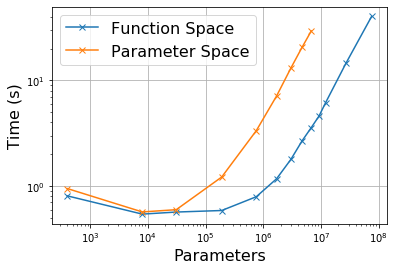

In [10]:
plt.plot(pars, im_list, marker = 'x', label = 'Function Space')
plt.plot(ps_pars, par_im_list, marker = 'x', label = 'Parameter Space')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend(fontsize=16)
plt.xlabel('Parameters', fontsize=16)
plt.ylabel('Time (s)', fontsize=16)
plt.savefig('ntk_p_speed.pdf', bbox_inches='tight')

In [11]:
with open('../data/ntk_mlp_varying_pars_speed_gp.pkl', 'wb') as handle:
    plot_dict = {
        'function_space': width_results_list,
        'parameter_space': ps_width_results_list,
    }
    pickle.dump(plot_dict, handle, pickle.HIGHEST_PROTOCOL)

In [13]:
torch.cuda.empty_cache()